# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [8]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [10]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [11]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [12]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [14]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [17]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [18]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:11<00:00, 1221.03it/s]


In [22]:
preprocessed_reviews[15002]

'two reviewers already spoken recent one attempting undermine first reviewer said actually first reviewer know talking green tea contain caffeine expert source caffeinealthough black tea thought highest caffeine content tea actually untrue green tea caffeine however must understood compounds caffeine green tea functions special balancing way caffeine green tea surrounding tannic acid compounds inhibit surging bloodstream sense caffeine green tea time released bloodstream time release effect makes stimulation gentle quite pleasant also allows us feel effects green tea extended period time outlasts effects experienced friends drinking coffee cola effect green tea makes us free agitation nervousness blissful stimulation feels good senses enough said enjoy tea'

# [4] Featurization

## [4.1] BAG OF WORDS

In [18]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [19]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [20]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [22]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [23]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8592404723167419), ('terrific', 0.8256568908691406), ('good', 0.8240469098091125), ('awesome', 0.8234334588050842), ('excellent', 0.8104087114334106), ('wonderful', 0.7730631232261658), ('amazing', 0.7538352012634277), ('perfect', 0.7398526668548584), ('decent', 0.721411943435669), ('nice', 0.706905722618103)]
[('greatest', 0.8042136430740356), ('tastiest', 0.7443652749061584), ('best', 0.7094506621360779), ('disgusting', 0.6532707214355469), ('coolest', 0.648635983467102), ('nastiest', 0.626747727394104), ('closest', 0.6160385608673096), ('horrible', 0.6064977049827576), ('smoothest', 0.5973740816116333), ('awful', 0.5962929725646973)]


In [24]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [40]:

from tqdm import tqdm
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance[0:5000], position = 0): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:18<00:00, 23.91it/s]
                                                                                                                       


                                                                                                                       

                                                                                                                       



100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:18<00:00, 19.32it/s]


# [5]Applying Decision Trees

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_score
from scikitplot.metrics import plot_confusion_matrix


In [23]:
x_train,x_test,y_train,y_test = train_test_split(preprocessed_reviews,final["Score"], test_size = 0.3)
    

In [40]:
from tqdm import tqdm
def DecisionTrees_train(x_tr, x_tst):
    #finding the best values of hyperparameters max_depth and min_samples_split
    train_scores = []
    cv_scores = []
    depth = [4,6, 8, 9,10,12,14,17]
    min_samples = [2,10,20,30,40,50]
    for d in tqdm(depth, position=0):
        for samples in min_samples:
            model = DecisionTreeClassifier(max_depth=d, min_samples_split=samples)
            model.fit(x_tr,y_train)
            train_proba = model.predict_proba(x_tr)
            train_score = roc_auc_score(y_train, train_proba[:,1])
            train_scores.append(train_score)
            #10 fold cross validation
            score = cross_val_score(model,x_tr,y_train,cv = 10, scoring='roc_auc', n_jobs=-1)
            cv_scores.append(score.mean())
    
    #reshaping auc scores as 2D matrix with depth as rows and min_samples as columns
    train_scores = np.array(train_scores)
    train_scores = train_scores.reshape((len(depth), len(min_samples)))
    cv_scores = np.array(cv_scores)
    cv_scores = cv_scores.reshape((len(depth),len(min_samples)))
    
    #plotting heatmaps
    sns.set_style("whitegrid")
    plt.figure(figsize = (8,6))
    sns.heatmap(train_scores,fmt = '.3f', cmap = "coolwarm", annot = True,xticklabels=min_samples, yticklabels = depth)
    plt.xlabel("min_samples_split")
    plt.ylabel("max_depth")
    plt.title("train roc auc scores")
    plt.show()
    
    plt.figure(figsize = (8,6))
    sns.heatmap(cv_scores,fmt = '.3f', cmap = "coolwarm", annot = True,xticklabels=min_samples, yticklabels= depth)
    plt.xlabel("min_samples_split")
    plt.ylabel("max_depth")
    plt.title("cross validation roc auc scores")
    plt.show()
    
    #getting the optimal values for hyperparameter
    print("Maximum CV score is" , np.amax(cv_scores))
    indexes = np.where(cv_scores == np.amax(cv_scores))
    optimal_depth = depth[int(indexes[0])]
    optimal_min_samples_split = min_samples[int(indexes[1])]
    print("Optimal value of max_depth is %d and min_sample_split is %d "%(optimal_depth,optimal_min_samples_split))
    
    return optimal_depth,optimal_min_samples_split

In [25]:
def test(x_tr,x_tst,optimal_depth, optimal_min_samples_split):
    #fitting optimal model
    model = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_samples_split)
    model.fit(x_tr,y_train)
    
    test_proba = model.predict_proba(x_tst)
    train_proba = model.predict_proba(x_tr)
    
    train_auc = roc_auc_score(y_train, train_proba[:,1])
    test_auc = roc_auc_score(y_test, test_proba[:,1])
    fpr, tpr, thresholds = roc_curve(y_train, train_proba[:,1])
    fpr1, tpr1, thresholds1 = roc_curve(y_test, test_proba[:,1])
    
    #plotting roc curves
    sns.set_style('whitegrid')
    #plot no skill
    plt.plot([0,1],[0,1],'b--')
    plt.plot(fpr,tpr, label = "train ROC " + str(train_auc))
    plt.plot(fpr1, tpr1, label = "test ROC " + str(test_auc))
    plt.title("ROC curves for train and test data")
    plt.legend()
    plt.show()
    print(" Test auc score is ", test_auc)
    
    #plotting confusion matrix
    y_pred = model.predict(x_tst)
    plot_confusion_matrix(y_test, y_pred,cmap = 'Greens', figsize = (6,6))
    plt.title("test data confusion matrix")
    plt.show()
    
    
    

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [26]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 10)
train_bow = count_vect.fit_transform(x_train)
test_bow  = count_vect.transform(x_test)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [15:29<00:00, 116.13s/it]


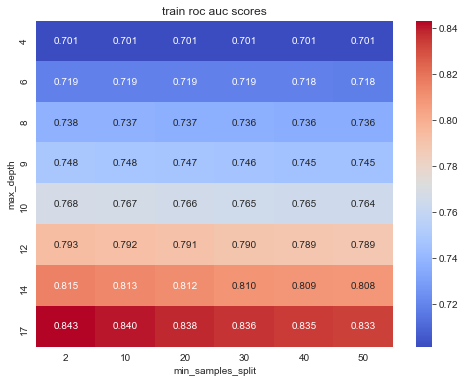

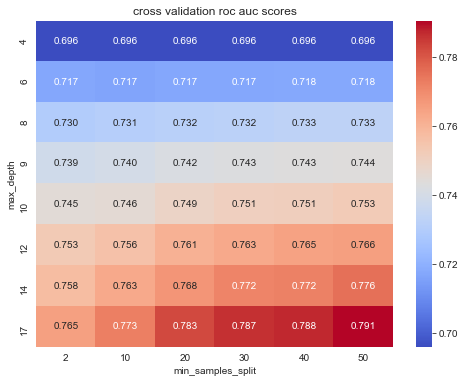

Maximum CV score is 0.7906403197989201
Optimal value of max_depth is 17 and min_sample_split is 50 


In [45]:
optimal_depth, optimal_min_samples_split = DecisionTrees_train(train_bow, test_bow)

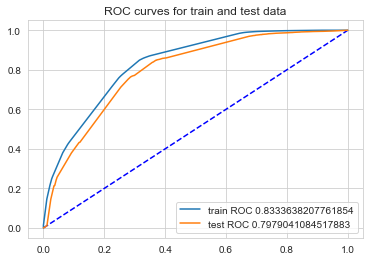

 Test auc score is  0.7979041084517883


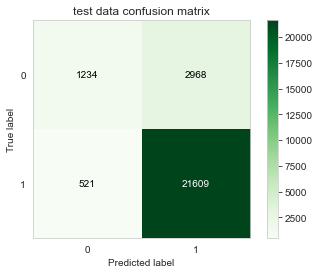

In [26]:
test(train_bow, test_bow, optimal_depth, optimal_min_samples_split)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [28]:
optimal_depth = 17
optimal_min_samples_split = 50

feat_name = count_vect.get_feature_names()

clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_samples_split)
clf.fit(train_bow, y_train)
feat_importance = clf.feature_importances_
feat_dict = dict(zip(feat_importance, feat_name))
feat_importance = sorted(feat_importance, reverse = True)
print("top 20 features are:")
print()
print("%30s\t%30s"%("feature_names","feature_importance"))
print("-"*100)
for imp in feat_importance[0:20]:
    print("%30s\t\t\t%f"%(feat_dict[imp],imp))

top 20 features are:

                 feature_names	            feature_importance
----------------------------------------------------------------------------------------------------
                           not			0.105048
                         great			0.077546
                         worst			0.046641
                       not buy			0.046595
                  disappointed			0.046579
                   waste money			0.043067
                        return			0.034332
                         awful			0.032146
                     not worth			0.030861
                          best			0.029384
                 not recommend			0.028987
              not disappointed			0.028858
                      terrible			0.028453
                     delicious			0.025454
                          love			0.023876
                          good			0.021707
                           bad			0.019108
                      not good			0.018385
                         loves			0.013135
                 

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

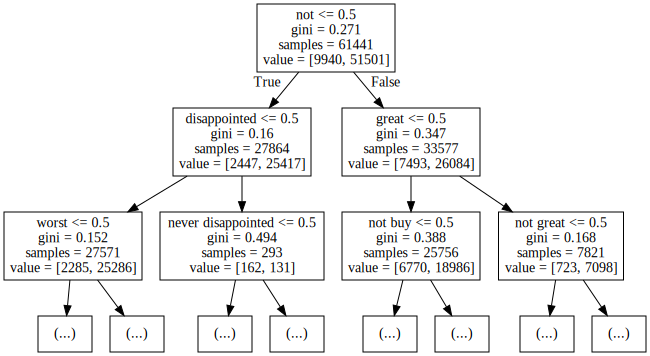

In [29]:
from sklearn import tree
from graphviz import Source
import graphviz
Source(tree.export_graphviz(clf, out_file=None, feature_names=feat_name, max_depth=2))


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [35]:

tfidf_vect = TfidfVectorizer(ngram_range = (1,2), min_df=2)
train_tfidf = tfidf_vect.fit_transform(x_train)
test_tfidf = tfidf_vect.transform(x_test)


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [48:58<00:00, 367.27s/it]


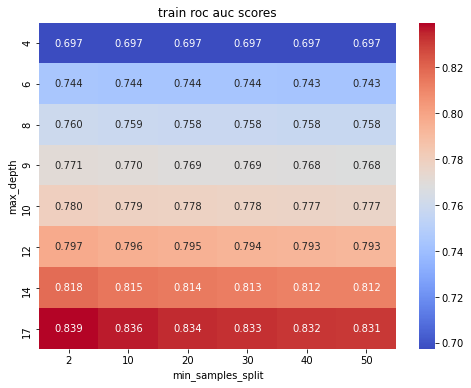

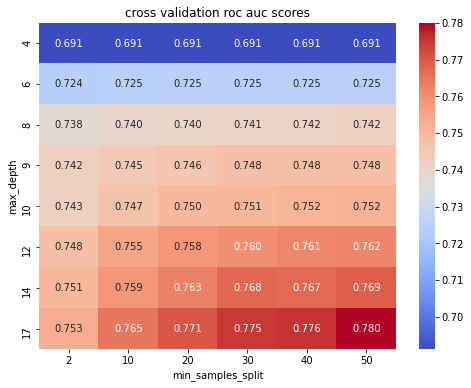

Maximum CV score is 0.7800169555803173
Optimal value of max_depth is 17 and min_sample_split is 50 


In [36]:
optimal_depth, optimal_min_samples_split = DecisionTrees_train(train_tfidf, test_tfidf)

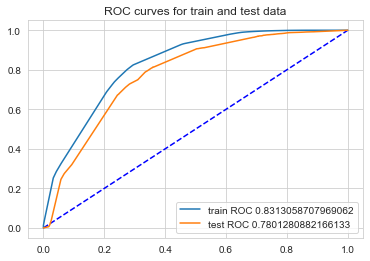

 Test auc score is  0.7801280882166133


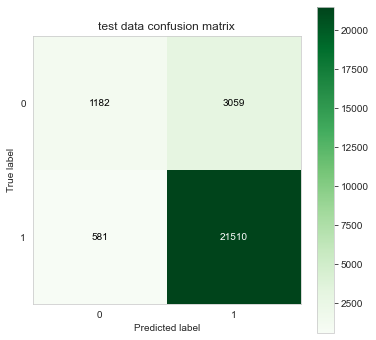

In [37]:
test(train_tfidf, test_tfidf, optimal_depth, optimal_min_samples_split)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [38]:
feat_name = tfidf_vect.get_feature_names()

clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_min_samples_split)
clf.fit(train_tfidf, y_train)
feat_importance = clf.feature_importances_
feat_dict = dict(zip(feat_importance, feat_name))
feat_importance = sorted(feat_importance, reverse = True)
print("top 20 features are:")
print()
print("%30s\t%30s"%("feature_names","feature_importance"))
print("-"*100)
for imp in feat_importance[0:20]:
    print("%30s\t\t\t%f"%(feat_dict[imp],imp))

top 20 features are:

                 feature_names	            feature_importance
----------------------------------------------------------------------------------------------------
                           not			0.140117
                         great			0.070694
                  disappointed			0.054250
                         worst			0.046444
                         awful			0.034535
                        return			0.033609
                       not buy			0.032000
                         waste			0.025808
                          good			0.025131
                     delicious			0.024904
                          best			0.023279
                      horrible			0.022292
              not disappointed			0.021627
                          love			0.021164
                 disappointing			0.020140
                      terrible			0.019137
                           bad			0.017484
                     not worth			0.017126
                   waste money			0.016341
                 

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

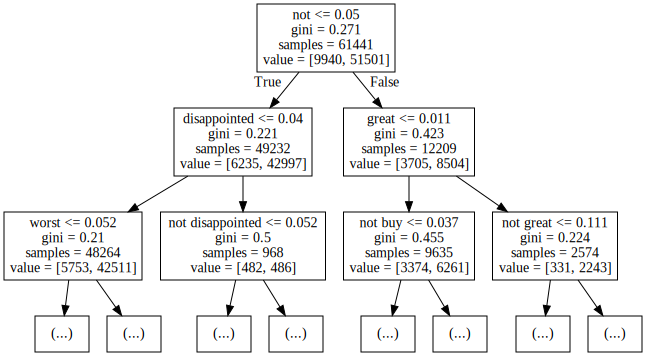

In [39]:
Source(tree.export_graphviz(clf, out_file=None, feature_names=feat_name, max_depth=2))

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [41]:
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
        
w2v=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2vwords = list(w2v.wv.vocab)

In [42]:
w2v.most_similar('great')

[('good', 0.8110492825508118),
 ('awesome', 0.8101460933685303),
 ('fantastic', 0.8042752742767334),
 ('excellent', 0.7932310104370117),
 ('terrific', 0.76551353931427),
 ('wonderful', 0.7400988936424255),
 ('perfect', 0.7318025827407837),
 ('fabulous', 0.6957256197929382),
 ('amazing', 0.6904552578926086),
 ('decent', 0.6716135144233704)]

In [46]:
def avgw2v(sentances):
    list_of_sentance=[]
    for sentance in sentances:
        list_of_sentance.append(sentance.split())
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    
    for sent in tqdm(list_of_sentance, position = 0): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2vwords:
                vec = w2v.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    

In [48]:
train_w2v = avgw2v(x_train)
test_w2v = avgw2v(x_test)

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [01:04<00:00, 406.88it/s]


In [54]:
from sklearn import preprocessing

std = preprocessing.StandardScaler()
train_w2v = std.fit_transform(train_w2v)
test_w2v = std.transform(test_w2v)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [12:44<00:00, 95.53s/it]


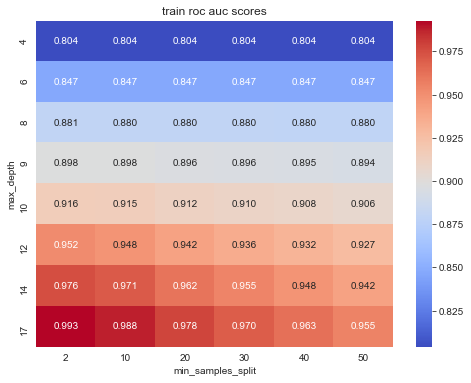

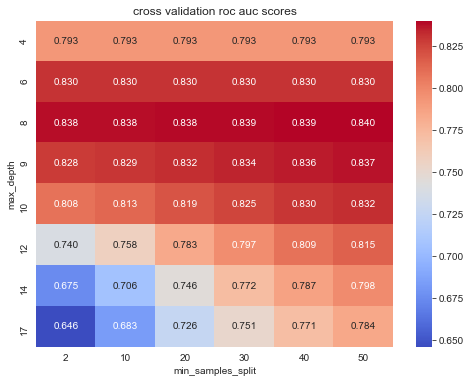

Maximum CV score is 0.8398075804554876
Optimal value of max_depth is 8 and min_sample_split is 50 


In [55]:
optimal_depth, optimal_min_samples_split = DecisionTrees_train(train_w2v,test_w2v)

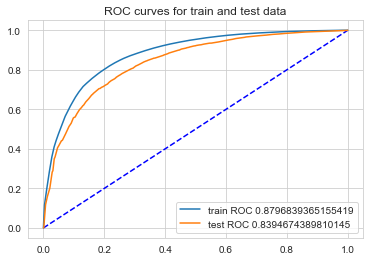

 Test auc score is  0.8394674389810145


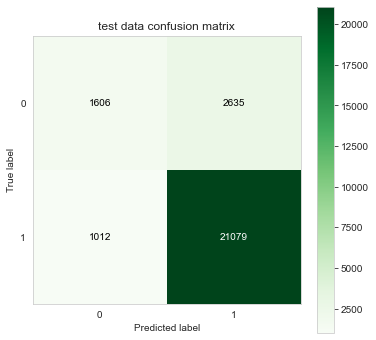

In [56]:
test(train_w2v, test_w2v, optimal_depth, optimal_min_samples_split)

# [6] Conclusions

In [57]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "optimal Max Depth", "optimal min_samples_split", "Test AUC Score"]
table.add_row(["Bag of Words", "Decision Tree Classifier", 17 , 50, 0.7979041084517883])
table.add_row(["TF-IDF", "Decision Tree Classifier", 17 , 50, 0.7801280882166133])
table.add_row(["Average Word2Vec", "Decision Tree Classifier",8, 50,0.8394674389810145])
print(table)

+------------------+--------------------------+-------------------+---------------------------+--------------------+
|    Vectorizer    |          Model           | optimal Max Depth | optimal min_samples_split |   Test AUC Score   |
+------------------+--------------------------+-------------------+---------------------------+--------------------+
|   Bag of Words   | Decision Tree Classifier |         17        |             50            | 0.7979041084517883 |
|      TF-IDF      | Decision Tree Classifier |         17        |             50            | 0.7801280882166133 |
| Average Word2Vec | Decision Tree Classifier |         8         |             50            | 0.8394674389810145 |
+------------------+--------------------------+-------------------+---------------------------+--------------------+
